In [ ]:
# Imports
from google.colab import drive
import urllib.request
import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
# per mostrare le barre di avanzamento
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Collegamento con il drive, variabili e funzioni generiche
# monto il drive
drive.mount('/content/drive', force_remount=True)
dataset_path = '/content/datasets/'
dataset_images_path = dataset_path + 'Images/'
drive_path = '/content/drive/MyDrive/progetti/machine_deep_learning/image_captioning/'
cache_file = drive_path + 'preprocessed.data.npz'
def download_dataset():
    urllib.request.urlretrieve("https://www.kaggle.com/api/v1/datasets/download/adityajn105/flickr8k","flickr-image-dataset.zip")
    with zipfile.ZipFile("flickr-image-dataset.zip", 'r') as zip_ref:
        if not os.path.exists(dataset_path):
            os.makedirs(dataset_path)
        zip_ref.extractall(dataset_path)
    print("Dataset scaricato con successo")
# Creo il modello per estrarre le features che è un sequenziale di un layer Xception e un AveragePooling
features_extractor = tf.keras.Sequential([
    tf.keras.applications.Xception(include_top=False),
    tf.keras.layers.GlobalAveragePooling2D()
])

Mounted at /content/drive
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Creazione classe per il modello
class ImageCaptioning:
    # Funzione costruttrice
    def __init__(self):
        # inizializzo gli attributi
        # salva il dataset pandas delle captions, prima riga "image" (NON UNIVOCA, ce ne sono 5) contiene il nome dell'immagine, seconda riga "caption" contiene le caption
        self.dataset = None
        # Quante captions ci sono per immagine
        self.captions_per_image = None
        # Dizionario che salva i nomi delle immagini e le relative features estratte {image1: [features], image2: [features] ...}, le features son tensori
        self.image_features_dict = {}
        # salva SOLO i nomi delle immagini divise per train, test e validation {train: [], validation: [], test: []}
        self.images_names_splitted = {}
        # Dizionario che converte i nomi delle immagini in un ID univoco
        self.images_IDs = {}
        # Tokenizzatore
        self.tokenizer = None
        # Lunghezza massima delle parole
        self.max_word_length = None
        # Dimensione del dizionario
        self.dictionary_size = None
        # Indice delle parole del tokenizzatore
        self.word_index = None
        # Matrice per la previsione
        self.matrix_y = None
        # Modello
        self.model = None
        # History
        self.history = None
    # Funzione per caricare un immagine, ridimensionarla e ritornarla come array numpy
    def load_image(self, image_path):
        with Image.open(image_path) as image:
            # Ridimensiono secondo le richieste di Xception
            image = image.resize((224, 224))
            # Converto in array numpy e ritorno
            return np.array(image) / 255
    # Funzione per caricare il dataset
    def load_dataset(self, dataset_path):
        # Leggo il dataset
        captions_dataset = pd.read_csv(dataset_path)
        # Calcolo quante captions per ogni immagine
        images_number = len(captions_dataset['image'].unique())
        captions_number = len(captions_dataset)
        self.captions_per_image = captions_number // images_number
        self.dataset = captions_dataset
    # Metodo per processare immagini in batch
    def batch_images_processing(self, images_path, batch_size):
        # Ottengo i nomi delle immagini che dovrò estrarre
        images_names = self.dataset['image'].unique()
        # Calcolo il numero di batch necessari
        num_batches = int(np.ceil(len(images_names) / batch_size))

        # ciclo su tutti i batch
        for batch_index in tqdm(range(num_batches)):
            # Calcolo l'indice di inizio e fine del batch
            start_index = batch_index * batch_size
            end_index = min((batch_index + 1) * batch_size, len(images_names))
            # Ottengo i nomi delle immagini del batch
            batch_images_names = images_names[start_index:end_index]
            # Creo una lista vuota per le features
            batch_features = []
            # Carico tutte le immagini del batch
            for image_name in batch_images_names:
                image_path = os.path.join(images_path, image_name)
                image = self.load_image(image_path)
                batch_features.append(image)
            # Converto la lista in un array numpy
            batch_features = np.array(batch_features)
            # Estraggo le features
            batch_features = features_extractor(batch_features)
            # Aggiungo le features al dizionario
            for image_name, feature in zip(batch_images_names, batch_features):
                self.image_features_dict[image_name] = feature
    # metodo per mescolare e dividere i nomi delle immagini in modo tale da avere train, validation e test sets
    def split_images_names(self, validation_ratio, test_ratio):
        # Ottengo la lista di tutte le immagini
        images_names = self.dataset['image'].unique()
        # Mescolo la lista
        np.random.shuffle(images_names)
        # Calcolo il numero di immagini per ogni set
        num_images = len(images_names)
        num_validation = int(num_images * validation_ratio)
        num_test = int(num_images * test_ratio)
        num_train = num_images - num_validation - num_test
        # Divido le immagini in train, validation e test
        self.images_names_splitted['train'] = images_names[:num_train]
        self.images_names_splitted['validation'] = images_names[num_train:num_train+num_validation]
        self.images_names_splitted['test'] = images_names[num_train+num_validation:]
    def create_image_IDs(self):
        # Ottengo la lista di tutti i nomi delle immagini
        images_names = self.dataset['image'].unique()
        # Itero sui nomi e creo l'ID
        for index, image_name in enumerate(images_names):
            self.images_IDs[image_name] = index
    # Metodo per processare le captions e tokenizzarle
    def process_captions(self):
        # Ottengo la lista di tutti i nomi
        images_names = self.dataset['image']
        # Ottengo la lista di tutte le captions
        captions = self.dataset['caption'].values
        # creo il tokenizzatore impostando il numero di parole al massimo possibile e togliendo tutti i filtri
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None, split=' ', filters='', oov_token='<unk>')
        # addestro il tokenizzatore sulle captions
        tokenizer.fit_on_texts(captions)
        # aggiungo al tokenizzatore un token per "<start>"
        tokenizer.word_index['<start>'] = len(tokenizer.word_index) + 1
        tokenizer.index_word[tokenizer.word_index['<start>']] = '<start>'
        # salvo il tokenizzatore
        self.tokenizer = tokenizer
        # tokenizzo le captions
        captions_tokenized_keras = tokenizer.texts_to_sequences(captions)
        # aggiungo il token "<start>" all'inizio delle captions tokenizzate
        captions_tokenized_keras = [[tokenizer.word_index['<start>']] + caption for caption in captions_tokenized_keras]
        # verifico che i nomi e i commenti tokenizzati siano della stessa lunghezza e in caso li unisco
        if len(images_names) == len(captions_tokenized_keras):
            list_of_tuples_names_tokens = list(zip(images_names, captions_tokenized_keras))
        else:
            print('Impossibile unire le liste di nomi e tokens')
            return

        # ora devo preparare la matrice da usare per il training
        # ottengo la lunghezza massima dei commenti
        max_word_length = max(len(caption) for caption in captions_tokenized_keras)
        self.max_word_length = max_word_length
        # ottengo la dimensione del dizionario
        dictionary_size = len(tokenizer.word_index)
        self.dictionary_size = dictionary_size
        # ottengo l'indice delle parole
        word_index = tokenizer.word_index
        self.word_index = word_index
        # il numero di colonne della matrice equivarrà alla lunghezza massima possibile più 2 righe, 1 per il prossimo valore da prevedere dati gli input e 1 per l'ID dell'immagine
        columns_number = max_word_length + 2
        # il numero di righe della matriche come la somma di tutte le parole da prevedere (escludendo "<start>") di tutte le frasi
        row_number = sum(len(string) - 1 for string in captions_tokenized_keras)
        # preparo una matrice di output vuota
        matrix_y = np.empty((row_number, columns_number), dtype=np.int32)
        row_number = 0
        # itero sulle tuple di nomi e captions tokenizzate
        for image_name, caption in list_of_tuples_names_tokens:
            # ottengo l'ID dell'immagine
            image_ID = self.images_IDs[image_name]
            # escludo il primo token che è start
            tokens = caption[1:]
            # usando numpy.tile creo una matrice ripetendo i tokens tante volte quanti sono i tokens
            matrix = np.tile([caption], (len(tokens),1))
            # ora devo fare in modo che ad ogni passaggio non vengano visti i passi successivi, quindi uso np.tril per tenere solo la parte in basso a sinistra della matrice e l'altra riempirla con 0
            matrix = np.tril(matrix)
            # effettuo il padding
            matrix = tf.keras.preprocessing.sequence.pad_sequences(matrix, columns_number, padding='post')
            # nella penultima colonna della matrice salverò i valori da predirre che sono salvati in "word_tokens", essi verranno "trasposti" (quindi il primo valore da predirre verrà messo nella prima riga, il secondo nella seconda e così via)
            matrix[:,-2] = tokens
            # nella ultima colonna della matrice salverò l'ID dell'immagine
            matrix[:,-1] = image_ID
            # unisco la matrice generata per la frase corrente a quella generale
            end_row_number = row_number + len(tokens)
            matrix_y[row_number:end_row_number] = matrix
            row_number = end_row_number
        # Salvo la matrice risultante
        self.matrix_y = matrix_y
    # Definisco il generatore dei dati
    def data_generator(self, image_names, batch_size):
        # ottengo le features come un dizionario {image_ID: [features]}
        image_features = {}
        for image_name in image_names:
            # converto il nome in ID
            image_ID = self.images_IDs[image_name]
            # salvo le features
            image_features[image_ID] = self.image_features_dict[image_name]
        # ottengo gli indici corrispondenti ai nomi delle immagini
        image_IDs = [self.images_IDs[image_name] for image_name in image_names]
        # Estraggo i dati `y` corrispondenti agli image_IDs
        mask = np.isin(self.matrix_y[:, -1], image_IDs)
        y = self.matrix_y[mask]
        # Ottengo il numero totale di esempi
        num_examples = y.shape[0]
        # Calcolo il numero di batch
        num_batches = int(np.ceil(num_examples / batch_size))
        # Loop infinito per generare i batch
        while True:
            # Mescolo gli indici di `y`
            shuffled_indices = np.random.permutation(num_examples)

            # Divido gli indici mescolati in batch
            for batch_start in range(0, num_examples, batch_size):
                batch_indices = shuffled_indices[batch_start:batch_start + batch_size]

                # Seleziono `y_batch` in base agli indici
                y_batch = y[batch_indices]

                # Ottengo gli ID corrispondenti agli indici selezionati
                batch_image_IDs = y_batch[:, -1]

                # Costruisco `x_batch` in base agli ID
                x_batch = np.array([image_features[image_ID].numpy() for image_ID in batch_image_IDs])

                # estraggo la y obiettivo che è la penultima colonna
                y_target = y_batch[:, -2:-1].astype(int)

                # Rimuovo le colonne di risultato e id immagine
                y_batch = y_batch[:, :-2]

                # Ritorno la tupla
                yield ((x_batch, y_batch), y_target)

    def create_model(self):
        # estraggo lo shape dalle features
        features = self.image_features_dict[list(self.image_features_dict.keys())[0]].numpy()
        # converto le variabili locali in int
        self.max_word_length = int(self.max_word_length)
        self.dictionary_size = int(self.dictionary_size)
        # Ottengo le dimensioni delle immagini
        image_input_shape = (features.shape[-1],)
        # Ottengo le dimensioni delle captions
        caption_input_shape = (self.max_word_length,)

        image_input = tf.keras.layers.Input(shape=image_input_shape)
        image_dense = tf.keras.layers.Dense(256, activation='relu')(image_input)

        caption_input = tf.keras.layers.Input(shape=caption_input_shape)
        caption_embedding = tf.keras.layers.Embedding(self.dictionary_size, 256, mask_zero = True)(caption_input)
        caption_lstm = tf.keras.layers.LSTM(512)(caption_embedding)
        concatenate = tf.keras.layers.Concatenate(axis=-1)([image_dense, caption_lstm])
        concatenate = tf.keras.layers.Dropout(0.6)(concatenate)
        output = tf.keras.layers.Dense(self.dictionary_size, activation='softmax')(concatenate)

        self.model = tf.keras.Model(inputs=[image_input, caption_input], outputs=output)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model.summary()

    def train(self, batch_size, epochs):
        self.create_model()
        #print(self.image_features_dict)
        features = []
        for image_name in self.image_features_dict.keys():
            features.append(self.image_features_dict[image_name].numpy())
        #print(features)
        features_shape = features[0].shape
        # Definisco le output signature
        output_signature = (
            (tf.TensorSpec(shape=(None, features_shape[0]), dtype=tf.float32),  # x_batch
            tf.TensorSpec(shape=(None, self.max_word_length), dtype=tf.int32)),  # y_batch
            tf.TensorSpec(shape=(None, 1), dtype=tf.int32)  # y_ohe
        )
        train_images = self.images_names_splitted['train']
        validation_images = self.images_names_splitted['validation']

        train = tf.data.Dataset.from_generator(
            lambda: self.data_generator(train_images, batch_size),
            output_signature=output_signature
        )

        validation = tf.data.Dataset.from_generator(
            lambda: self.data_generator(validation_images, batch_size),
            output_signature=output_signature
        )

        # Calculate total examples for train and validation
        total_train_examples = sum(len(caption) - 1 for image_name, caption in list(zip(self.dataset['image'], self.dataset['caption'].values))
                                    if image_name in train_images)
        total_validation_examples = sum(len(caption) - 1 for image_name, caption in list(zip(self.dataset['image'], self.dataset['caption'].values))
                                        if image_name in validation_images)

        # calcolo quanti step saranno necessari
        steps_per_epoch = int(np.ceil(total_train_examples / batch_size))
        validation_steps = int(np.ceil(total_validation_examples / batch_size))

        earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

        # provo ad usare la GPU
        if tf.config.list_physical_devices('GPU'):
            print("GPU disponibile, uso GPU per l'elaborazione.")
            with tf.device('/device:GPU:0'):
                self.model.fit(train, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation, validation_steps=validation_steps, callbacks=[earlystopping])
                # salvo la storia
                self.history = self.model.history
        else:
            print("GPU non disponibile, l'addestramento sarebbe eterno, connetti una GPU")
            return
    # Metodo per testare il funzionamento
    def test(self, test_size_number):
        # se le immagini non sono presenti le scarico
        if not os.path.exists(dataset_images_path): download_dataset()
        # seleziono dal dataset di test
        test_images_names = np.random.choice(self.images_names_splitted['test'], test_size_number, replace=False)

        features = []
        for image_name in test_images_names:
            image_path = os.path.join(dataset_images_path, image_name)
            image = self.load_image(image_path)
            features.append(image)
        # Converto la lista in un array numpy
        features = np.array(features)
        # Estraggo le features
        features = features_extractor(features)
        print("Immagini processate correttamente")

        # per ogni immagine
        for image_name, image_features in zip(test_images_names, features):
            # ottengo dal dizionario il token corrispondente a "<start>"
            start_token = self.word_index['<start>']
            # inizializzo il testo dell'immagine che ha come primo elemento il token di "<start>"
            caption = np.zeros((1, self.max_word_length), dtype=int)
            caption[:, 0] = start_token
            # predico la frase
            for i in range (1 , self.max_word_length):
                prediction = self.model.predict([image_features.numpy().reshape(1, -1), caption], verbose = 0)
                # ottengo l'indice della parola più probabile
                predicted_word = np.argmax(prediction, axis = 1)
                predicted_word = predicted_word.astype(int)
                # l'aggiungo alla caption
                caption[:,i] = predicted_word[0]
                # se è il token del "." taglio le restanti ed interrompo
                if predicted_word == self.word_index['.']:
                    caption = caption[:,:i+1]
                    break
            # elimino il primo token di start
            caption = caption[:,1:]
            # traduco la caption
            caption = self.tokenizer.sequences_to_texts(caption)
            # stampo il risultato e l'immagine
            print(caption)
            # ottengo l'immagine corrispondente
            image = Image.open(dataset_images_path + image_name)
            # mostro l'immagine
            plt.imshow(image)
            plt.show()
    # Metodo per salvare tutte le informazioni necessarie per ricreare la classe dato l'url di una cartella
    def save(self, url):
        pickle.dump(self, open(url, 'wb'))
        # salvo separatamente il tokenizer
        pickle.dump(self.tokenizer, open(url + 'tokenizer.pkl', 'wb'))
        # salvo separatamente il dizionario delle features
        pickle.dump(self.image_features_dict, open(url + 'image_features_dict.pkl', 'wb'))
    # carico il modello
    def load(self, url):
        self = pickle.load(open(url, 'rb'))
        self.tokenizer = pickle.load(open(url + 'tokenizer.pkl', 'rb'))
        self.image_features_dict = pickle.load(open(url + 'image_features_dict.pkl', 'rb'))
        return self
image_captioning = ImageCaptioning()

In [ ]:
# Verifico se la classe è già presente sul drive
if os.path.exists(drive_path + 'image_captioning.pkl'):
    image_captioning = image_captioning.load(drive_path + 'image_captioning.pkl')
else:
    # carico dal drive il csv delle descrizioni
    captions_dataset_path = drive_path + 'captions.csv'
    image_captioning.load_dataset(captions_dataset_path)
    # se le immagini non sono presenti le scarico
    if not os.path.exists(dataset_images_path): download_dataset()
    # se il dataset è presente sul drive lo carico e lo imposto nella classe
    if os.path.exists(drive_path + 'image_features_dict.pkl'):
        image_captioning.image_features_dict = pickle.load(open(drive_path + 'image_features_dict.pkl', 'rb'))
        print('Dizionario Features caricato')
    # altrimenti le genero
    else:
        if tf.config.list_physical_devices('GPU'):
            print("GPU disponibile, uso GPU per l'elaborazione.")
            with tf.device('/device:GPU:0'):
                image_captioning.batch_images_processing(dataset_images_path, 64)
        else:
            print("GPU non disponibile, uso CPU per l'elaborazione.")
            image_captioning.batch_images_processing(dataset_images_path, 8)
        # Salva il dataset
        pickle.dump(image_captioning.image_features_dict, open(drive_path + 'image_features_dict.pkl', 'wb'))
        print('Dataset salvato')
    # divido le immagini
    image_captioning.split_images_names(0.2, 0.1)
    # creo gli ID delle immagini
    image_captioning.create_image_IDs()
    # processo le captions
    image_captioning.process_captions()
    # Eseguo l'addestramento
    image_captioning.train(10400, 100)
    # Salvo il modello
    image_captioning.save(drive_path + 'image_captioning.pkl')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 39)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 39, 256)        │      2,283,520 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 39)             │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 512)            │      1,574,912 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 768)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 768)            │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 8920)           │      6,859,480 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,242,456 (42.89 MB)

 Trainable params: 11,242,456 (42.89 MB)

 Non-trainable params: 0 (0.00 B)

GPU disponibile, uso GPU per l'elaborazione.
Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 104s 651ms/step - accuracy: 0.1684 - loss: 5.7566 - val_accuracy: 0.3258 - val_loss: 3.7089
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 95s 644ms/step - accuracy: 0.3334 - loss: 3.4750 - val_accuracy: 0.3647 - val_loss: 3.3330
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 95s 644ms/step - accuracy: 0.3688 - loss: 3.0169 - val_accuracy: 0.3793 - val_loss: 3.2186
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 95s 640ms/step - accuracy: 0.3909 - loss: 2.7655 - val_accuracy: 0.3887 - val_loss: 3.1849
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 95s 640ms/step - accuracy: 0.4128 - loss: 2.5746 - val_accuracy: 0.3925 - val_loss: 3.1738
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 95s 644ms/step - accuracy: 0.4296 - loss: 2.4485 - val_accuracy: 0.3963 - val_loss: 3.1656
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 94s 637ms/step - accuracy: 0.4451 - loss: 2.3352 - val_accuracy: 0.3959 - val_loss: 3.1867
Epoch 8/100
148/148 ━━━━━━━━━━

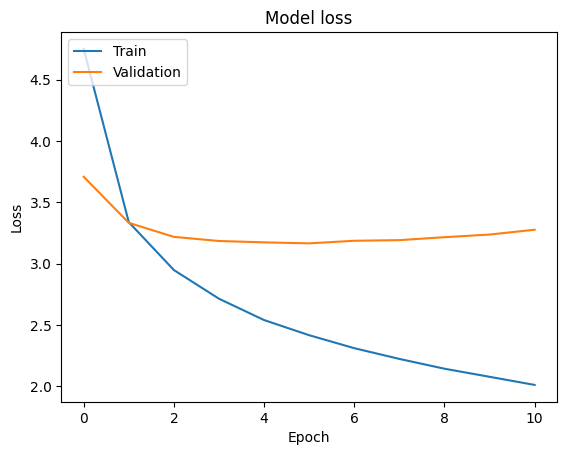

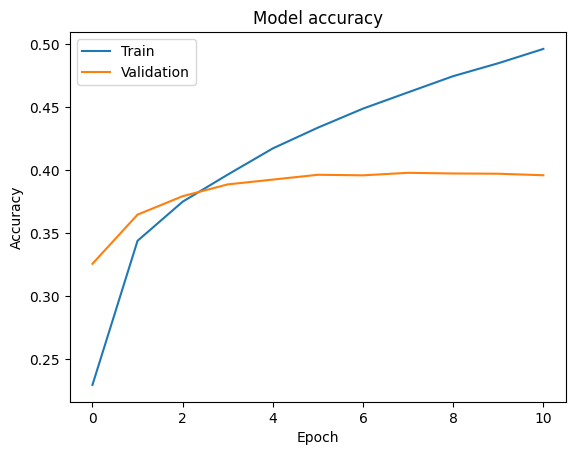

In [ ]:
# Stampo i grafici della loss e dell'accuratezza dalla storia
plt.plot(image_captioning.history.history['loss'])
plt.plot(image_captioning.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(image_captioning.history.history['accuracy'])
plt.plot(image_captioning.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

GPU disponibile, uso GPU per l'elaborazione.
Immagini processate correttamente
['a man in a black shirt is riding a motorcycle .']


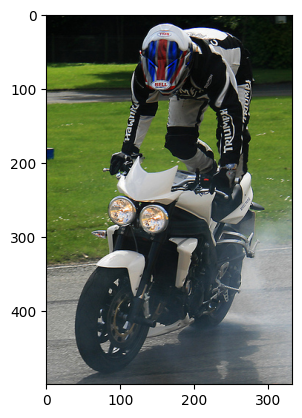

['a dog is running through the grass .']


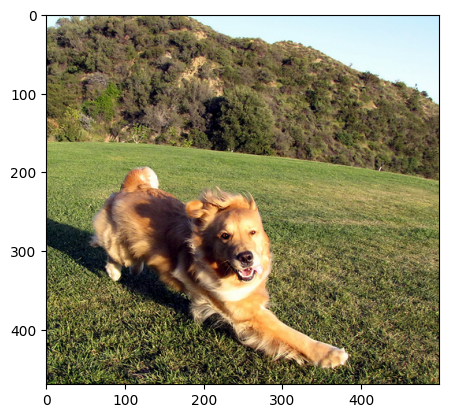

['a man in a red shirt and a woman in a red jacket and a woman in a red jacket are standing in front of a brick wall .']


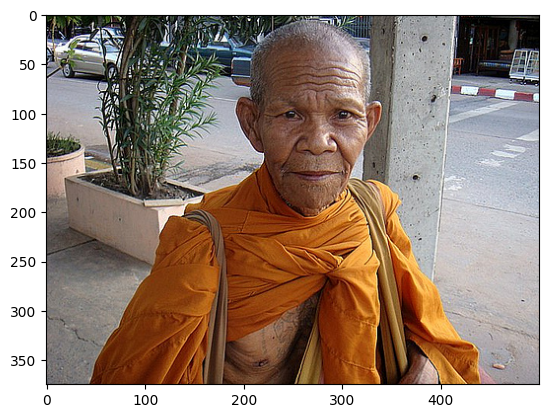

['a man in a red shirt is standing in front of a large red and white building .']


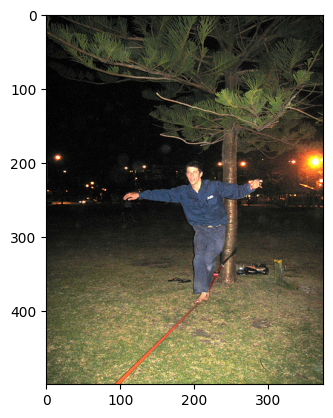

['a dog is running through the water .']


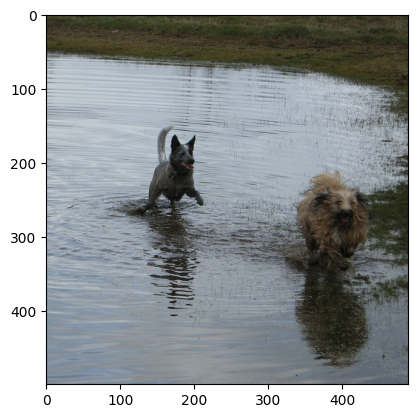

In [ ]:
# Effettuo delle predizioni
if tf.config.list_physical_devices('GPU'):
    print("GPU disponibile, uso GPU per l'elaborazione.")
    with tf.device('/device:GPU:0'):
        image_captioning.test(5)
else:
    print("GPU non disponibile, uso CPU per l'elaborazione.")
    image_captioning.test(5)